Datathon - Machine Learning Engineering - Grupo 34 - Pos Tech FIAP - 22/05/2025

Applicants

In [1]:
import os
import pandas as pd
import json

def encontrar_arquivo(nome_arquivo, pasta_inicial="."):
    """Busca um arquivo pelo nome a partir da pasta especificada (padrão: pasta atual)."""
    for root, _, files in os.walk(pasta_inicial):
        if nome_arquivo in files:
            return os.path.join(root, nome_arquivo)
    return None

def processar_json(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    registros = []
    for id_profissional, dados in data.items():
        registro = {"id_candidato": id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as seções do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a seção tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor único (ex: cv_pt, cv_en, cargo_atual vazio)
                registro[secao] = valores
        
        registros.append(registro)

    return pd.DataFrame(registros)

# Nome do arquivo JSON
nome_arquivo = "applicants.json"

# Buscar o arquivo no sistema
caminho_arquivo = encontrar_arquivo(nome_arquivo)

if caminho_arquivo:
    applicants = processar_json(caminho_arquivo)
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")

Arquivo encontrado e carregado com sucesso!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
applicants.shape

(42482, 55)

Vagas

In [4]:
import os
import pandas as pd
import json

def encontrar_arquivo(nome_arquivo, pasta_inicial="."):
    """Busca um arquivo pelo nome a partir da pasta especificada (padrão: pasta atual)."""
    for root, _, files in os.walk(pasta_inicial):
        if nome_arquivo in files:
            return os.path.join(root, nome_arquivo)
    return None

def processar_json(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    registros = []
    for id_profissional, dados in data.items():
        registro = {"id_vaga": id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as seções do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a seção tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor único
                registro[secao] = valores
        
        registros.append(registro)
    
    return pd.DataFrame(registros)

# Nome do arquivo JSON
nome_arquivo = "vagas.json"

# Buscar o arquivo no sistema
caminho_arquivo = encontrar_arquivo(nome_arquivo)

if caminho_arquivo:
    vagas = processar_json(caminho_arquivo)
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")

Arquivo encontrado e carregado com sucesso!


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
vagas.shape

(14081, 45)

Prospects

In [7]:
import pandas as pd
import json

def processar_json_para_dataframe(json_data):
    dados = []

    for id_vaga, vaga_info in json_data.items():
        titulo = vaga_info.get("titulo", "")
        modalidade = vaga_info.get("modalidade", "")

        # Se houver uma lista dentro do JSON, criamos múltiplas linhas
        if "prospects" in vaga_info:
            for prospect in vaga_info["prospects"]:
                linha = {"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade}
                linha.update(prospect)  # Adiciona os dados de prospects como colunas
                dados.append(linha)
        else:
            dados.append({"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade})

    return pd.DataFrame(dados)

# Caminho do arquivo JSON
caminho_arquivo = "prospects.json"

# Carregar JSON
with open(caminho_arquivo, "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Converter para DataFrame
prospects = processar_json_para_dataframe(json_data)

In [8]:
pd.set_option('display.max_columns', None)
# Renomeando a coluna 'codigo' para 'id_candidato'
prospects.rename(columns={'codigo': 'id_candidato', 'cidade': 'cidade_vaga'}, inplace=True)

In [9]:
prospects.shape

(53759, 10)

Análise Exploratória de Dados

In [10]:
# Unir Prospects com Applicants (vaga -> candidato)
prospects_applicants = prospects.merge(applicants, left_on="id_candidato", right_on="id_candidato", how="left")

# Unir com Vagas (vaga -> detalhes da vaga)
df = prospects_applicants.merge(vagas, left_on="id_vaga", right_on="id_vaga", how="left")

In [11]:
df.shape

(53759, 108)

In [12]:
# Remover 'nome_y'
df = df.drop(columns=['nome_y'], errors='ignore')

# Renomear colunas
df = df.rename(columns=lambda col: col.replace('_x', '_candidato').replace('_y', '_vaga'))
df = df.rename(columns={"local": "cidade_candidato", "cidade": "cidade_vaga", "nivel profissional": "nivel_profissional_vaga", 
                        "areas_atuacao": "areas_atuacao_vaga", "nivel_profissional": "nivel_profissional_candidato",
                        "cursos": "cursos_candidato", "remuneracao": "remuneracao_candidato"})

In [13]:
# Separando as colunas a serem usadas

df = df[['situacao_candidado','recrutador','cidade_candidato',
                'data_nascimento','sexo','estado_civil','pcd','remuneracao_candidato','nivel_profissional_candidato',
                'nivel_academico_candidato',
                'nivel_ingles_candidato','nivel_espanhol_candidato','cursos_candidato',
                'cliente_vaga','tipo_contratacao',
                'prioridade_vaga','origem_vaga','cidade_vaga',
                'nivel_profissional_vaga','nivel_academico_vaga','nivel_ingles_vaga','nivel_espanhol_vaga',
                'areas_atuacao_vaga','ultima_atualizacao']]

In [14]:
df.shape

(53759, 24)

In [15]:
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas duplicadas: 8274


In [16]:
df.drop_duplicates(inplace=True)  # Remove duplicatas

In [17]:
# Convertendo as colunas para datetime, tratando erros
df[['data_nascimento','ultima_atualizacao']] = df[
    ['data_nascimento','ultima_atualizacao']].apply(
    lambda col: pd.to_datetime(col, errors='coerce', format='%d-%m-%Y'))

In [18]:
# Extraindo apenas os números e convertendo para inteiro
df['remuneracao_candidato'] = (
    df['remuneracao_candidato']
    .str.replace(r'[^\d,.-]', '', regex=True)  # Remove tudo que não for número, vírgula, ponto ou hífen
    .str.replace(',', '.', regex=False)  # Substitui vírgula por ponto
    .str.extract(r'(-?\d+\.?\d*)')  # Captura o primeiro número válido
    .astype(float)  # Converte para float primeiro
    .fillna(0)  # Substitui NaN por 0 (opcional)
    .astype(int)  # Converte para inteiro
)

In [19]:
# Calculando a idade (diferenca entre anos)
df['idade'] = df['ultima_atualizacao'].dt.year - df['data_nascimento'].dt.year
# Removendo as colunas 'data_nascimento' e 'ultima_atualizacao'
df = df.drop(columns=['data_nascimento', 'ultima_atualizacao'])

In [20]:
df.describe(include="all")

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
count,45485,45485,39281,39281,39281,39281,4.548500e+04,39281,39281,39281,39281,10901,45462,45462,45462,45462,45462,45462,45462,45462,45462,45462,14114.000000
unique,21,77,615,3,7,3,NaN,10,22,6,6,127,111,40,4,3,155,14,15,6,7,71,NaN
top,Prospect,Srta. Bella Ferreira,,,,,NaN,,,,,,Morrison Ltd,PJ/Autônomo,Alta: Alta complexidade 3 a 5 dias,Nova Posição,São Paulo,Sênior,Ensino Superior Completo,Básico,Nenhum,TI - Projetos-,NaN
freq,15430,4462,18802,26683,28605,28974,NaN,38988,27564,28092,28392,1065,6274,15694,30139,30012,32801,18014,35135,15790,20235,18005,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.996147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.983562
std,NaN,NaN,NaN,NaN,NaN,NaN,1.455928e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.234396
min,NaN,NaN,NaN,NaN,NaN,NaN,-4.700000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45485 entries, 0 to 53758
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   situacao_candidado            45485 non-null  object 
 1   recrutador                    45485 non-null  object 
 2   cidade_candidato              39281 non-null  object 
 3   sexo                          39281 non-null  object 
 4   estado_civil                  39281 non-null  object 
 5   pcd                           39281 non-null  object 
 6   remuneracao_candidato         45485 non-null  int32  
 7   nivel_profissional_candidato  39281 non-null  object 
 8   nivel_academico_candidato     39281 non-null  object 
 9   nivel_ingles_candidato        39281 non-null  object 
 10  nivel_espanhol_candidato      39281 non-null  object 
 11  cursos_candidato              10901 non-null  object 
 12  cliente_vaga                  45462 non-null  object 
 13  tipo_c

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

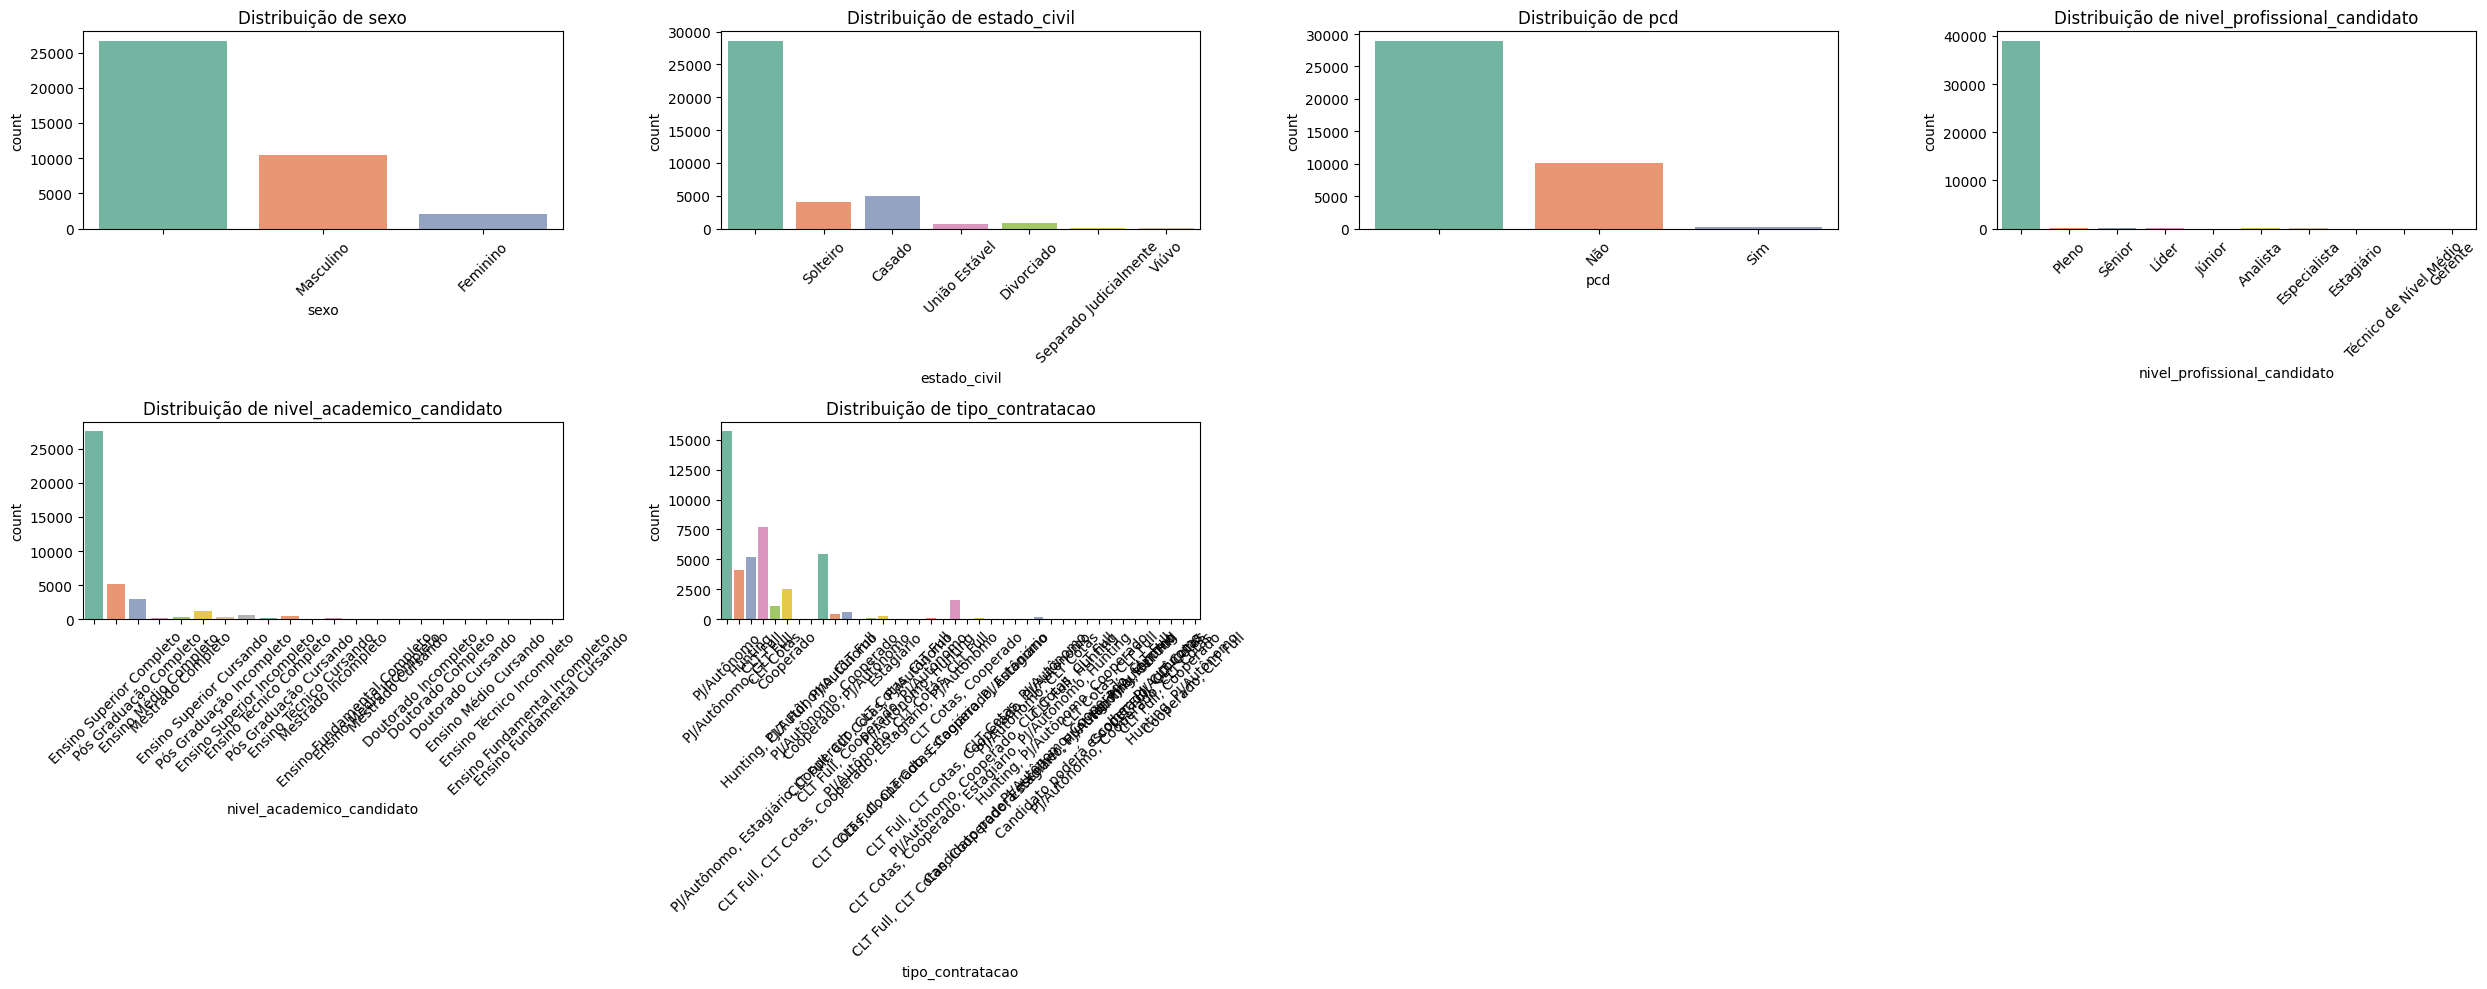

In [23]:
import warnings
warnings.filterwarnings("ignore")

# Gráficos de barras para variáveis categóricas
categorical_columns = ['sexo', 'estado_civil', 'pcd', 'nivel_profissional_candidato', 'nivel_academico_candidato', 'tipo_contratacao']

plt.figure(figsize=(25, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=df[col], palette='Set2')
    plt.title(f'Distribuição de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

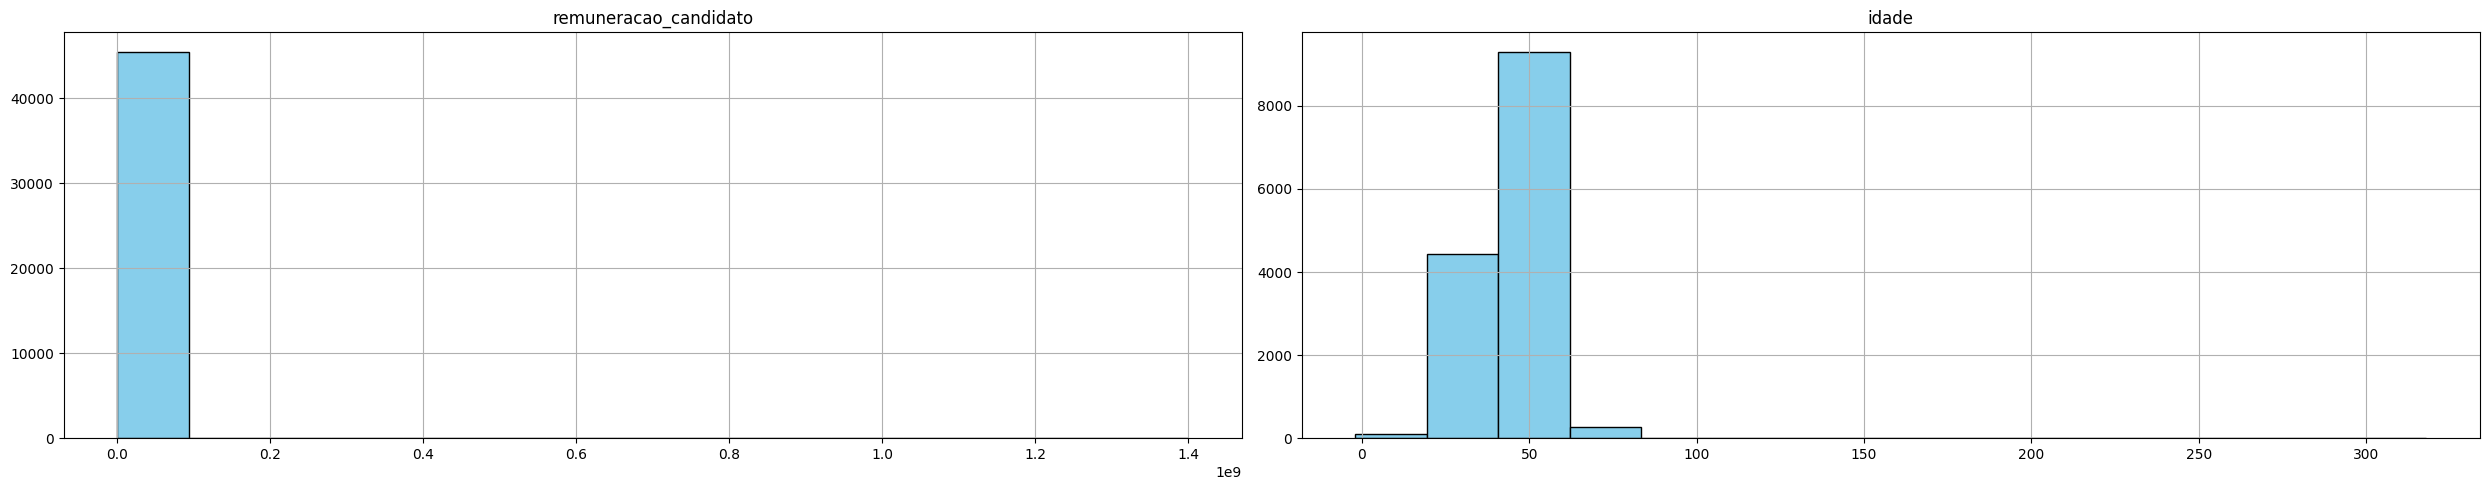

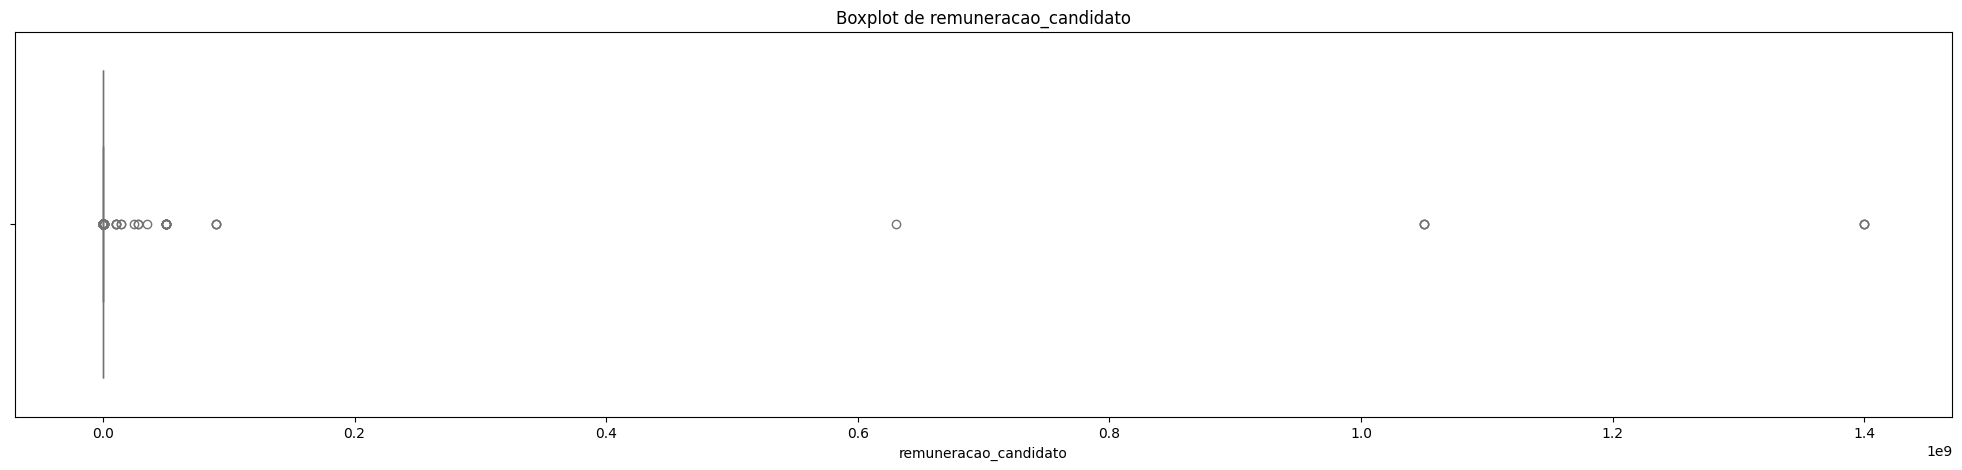

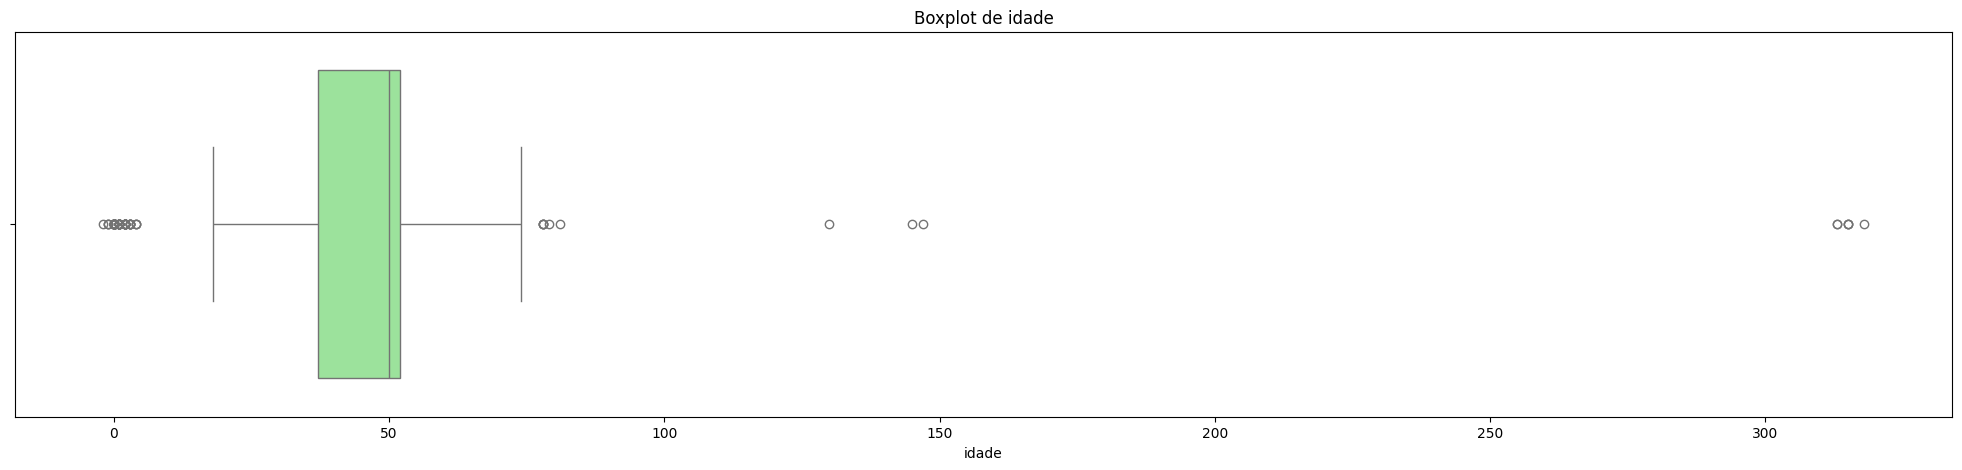

In [24]:
# Histograma para variáveis numéricas
numeric_columns = ['remuneracao_candidato', 'idade']
df[numeric_columns].hist(bins=15, figsize=(25, 5), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Boxplot para detectar outliers
for col in numeric_columns:
    plt.figure(figsize=(25, 5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.show()

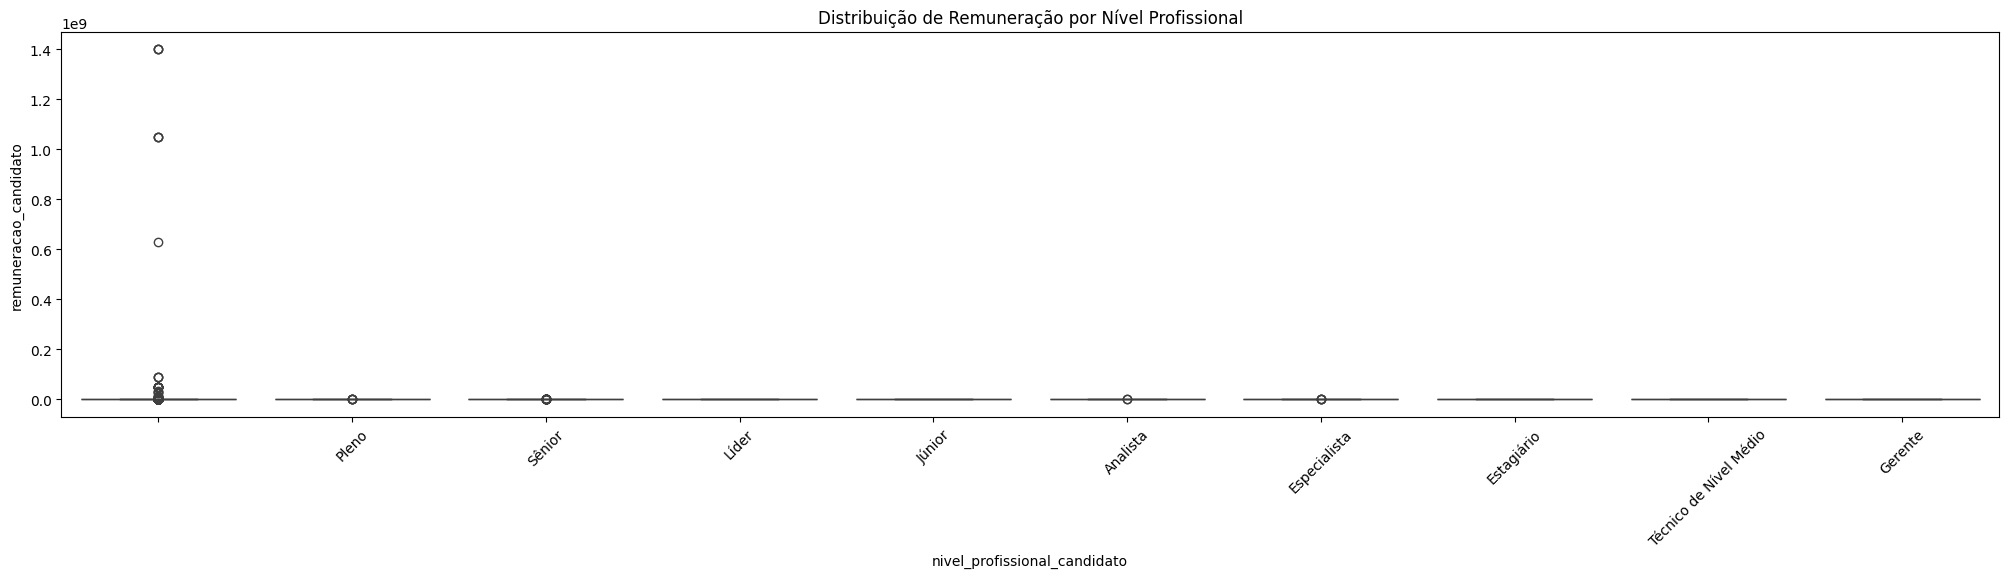

In [25]:
# Exemplo para 'remuneracao' e 'nivel_profissional'
plt.figure(figsize=(25, 5))
sns.boxplot(x='nivel_profissional_candidato', y='remuneracao_candidato', data=df)
plt.title('Distribuição de Remuneração por Nível Profissional')
plt.xticks(rotation=45)
plt.show()

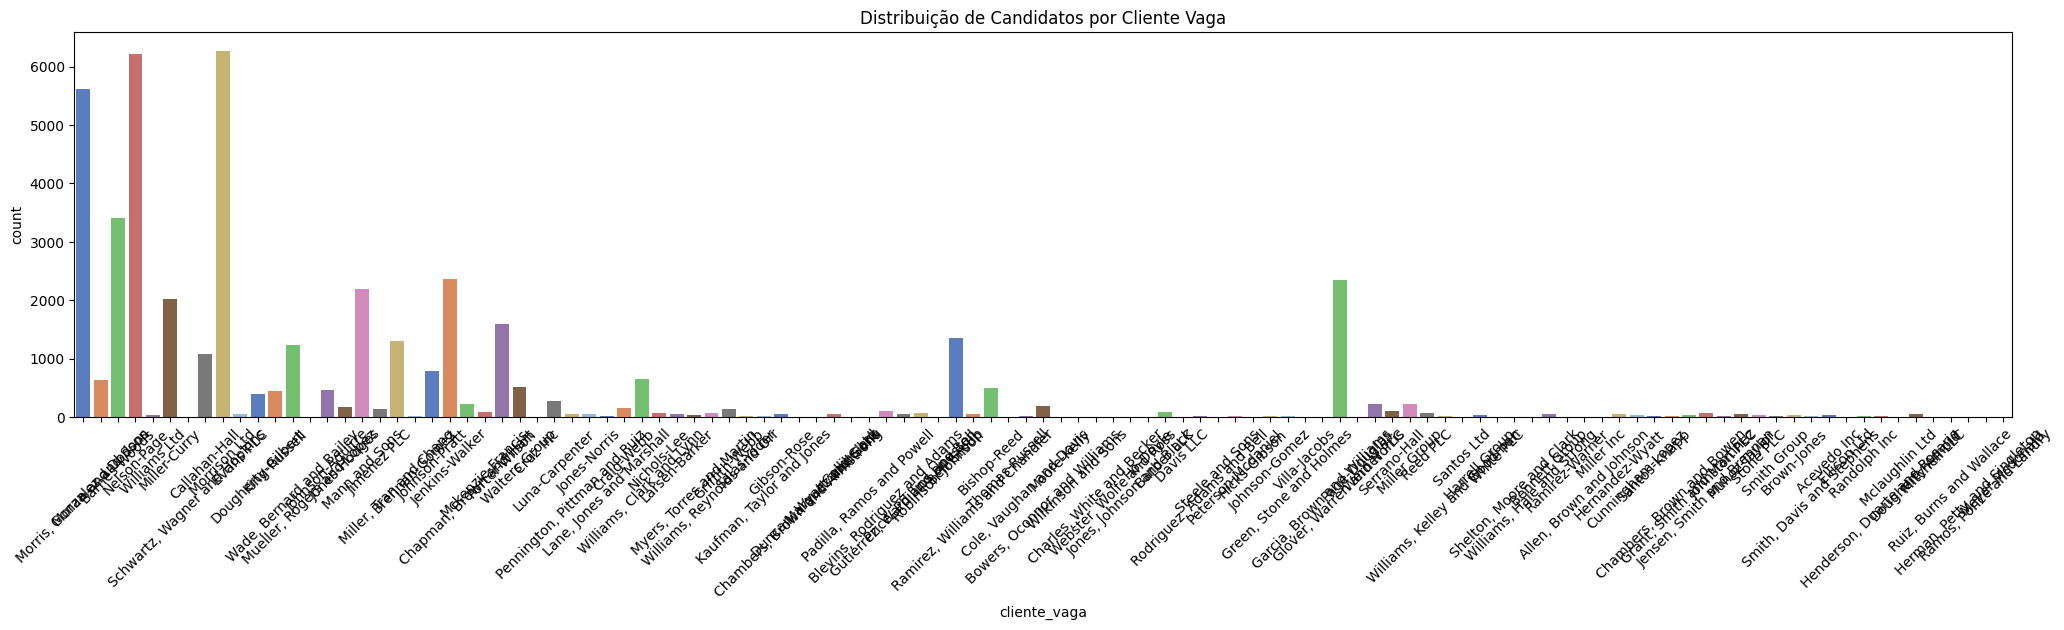

In [26]:
# Distribuição de candidatos por tipo de vaga
plt.figure(figsize=(25, 5))
sns.countplot(x='cliente_vaga', data=df, palette='muted')
plt.title('Distribuição de Candidatos por Cliente Vaga')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Visualizando valores extremos
df[df['idade'] < 18].head(1)  # Se houver idades menores que 18, pode ser um erro

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
41,Prospect,Ana Camargo,"Brasília, Distrito Federal",Masculino,Solteiro,Não,10300,,Ensino Superior Completo,Intermediário,Básico,Sistemas de Informação,Gonzalez and Sons,Hunting,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Financeira/Controladoria-,0.0


In [28]:
# Visualizando valores extremos
df[df['remuneracao_candidato'] > 1000000].head(1)  # Verificando se há remunerações extremamente altas

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
4688,Prospect,Yasmin da Rosa,"Araguari, Minas Gerais",Masculino,Casado,Não,50001600,,Ensino Superior Completo,Intermediário,Básico,Engenharia de Controle e Automação,Jenkins-Walker,Hunting,Alta: Alta complexidade 3 a 5 dias,,São Leopoldo,Sênior,Ensino Superior Completo,Avançado,Avançado,TI - Infraestrutura-,49.0


Feature Engineering e pré-processamento

In [29]:
valores_positivos = ['Contratado pela Decision', 'Aprovado', 'Contratado como Hunting', 'Proposta Aceita']
df['situacao_candidado'] = df['situacao_candidado'].isin(valores_positivos).astype(int)

In [30]:
df['situacao_candidado'].value_counts()

situacao_candidado
0    42543
1     2942
Name: count, dtype: int64

In [31]:
# X: todas as colunas, exceto a variável target
X = df.drop(columns=["situacao_candidado"])

# y: apenas a variável target
y = df["situacao_candidado"]

In [32]:
# Remover linhas com qualquer valor NaN
X = X.dropna()
y = y[X.index]  # Manter o mesmo índice de X

In [33]:
# Label Encoding (Se as categorias forem ordinais, ou seja, possuem uma ordem)

from sklearn.preprocessing import LabelEncoder

# Supondo que 'coluna_categorica' seja a sua coluna categórica
le = LabelEncoder()

# Lista das colunas a codificar
colunas_categoricas = ['nivel_profissional_candidato', 'nivel_academico_candidato', 'nivel_ingles_candidato', 
                       'nivel_espanhol_candidato', 'prioridade_vaga', 'nivel_profissional_vaga', 
                       'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 'sexo', 'estado_civil', 'pcd','recrutador', 'cidade_candidato','cursos_candidato','cliente_vaga', 'tipo_contratacao',
                       'origem_vaga', 'cidade_vaga','areas_atuacao_vaga']

# Aplicando o LabelEncoder em cada coluna categórica
for coluna in colunas_categoricas:
    X[coluna] = le.fit_transform(X[coluna])

In [34]:
# Balanceando a variável target

from imblearn.over_sampling import SMOTE

X, y = SMOTE().fit_resample(X, y)

In [35]:
# Normalização/Escalonamento dos dados

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [36]:
# Remoção de Variáveis Irrelevantes

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)  # Escolhe as 10 melhores variáveis
X_selected = selector.fit_transform(X_normalized, y)

# Ver quais variáveis foram selecionadas
selected_features = X.columns[selector.get_support()]
selected_features

Index(['sexo', 'nivel_academico_candidato', 'nivel_ingles_candidato',
       'tipo_contratacao', 'prioridade_vaga', 'origem_vaga',
       'nivel_profissional_vaga', 'nivel_academico_vaga',
       'nivel_espanhol_vaga', 'areas_atuacao_vaga'],
      dtype='object')

In [37]:
from scipy import stats

# Identificando outliers
z_scores = stats.zscore(X_selected)
outliers = (z_scores > 3).any(axis=1)

# Remover outliers
X_no_outliers = X_selected[~outliers]
y_no_outliers = y[~outliers]

In [38]:
df.shape

(45485, 23)

In [39]:
import pandas as pd

# Transformando X_selected de volta para um DataFrame com os nomes das variáveis selecionadas
df = pd.DataFrame(X_selected, columns=selected_features)

# Adicionando a coluna y como 'situacao_candidato'
df['situacao_candidato'] = y.values

# Visualizando o DataFrame resultante
df.head()

,sexo,nivel_academico_candidato,nivel_ingles_candidato,tipo_contratacao,prioridade_vaga,origem_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,situacao_candidato
0,0.587252,-0.825688,1.367198,1.017426,-0.986141,-1.009054,0.478080,0.062657,0.933267,-0.084790,0
1,0.587252,-0.825688,-0.985681,1.017426,3.154560,0.886117,0.924678,-1.514144,0.933267,-1.503229,1
2,0.587252,-0.825688,0.582905,1.017426,3.154560,0.886117,0.924678,-1.514144,0.933267,-1.503229,0
3,0.587252,-0.825688,-0.201388,1.017426,3.154560,0.886117,0.924678,-1.514144,0.933267,-1.503229,0
4,0.587252,-0.825688,1.367198,1.329932,0.394093,-1.009054,-1.531610,0.062657,-0.966004,0.655265,0


In [40]:
df.shape

(15200, 11)

In [41]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Converta X_selected de volta para um DataFrame (com as colunas originais)
X = pd.DataFrame(X_selected, columns=['sexo', 'nivel_ingles_candidato', 'tipo_contratacao', 
                                                  'prioridade_vaga', 'origem_vaga', 'nivel_profissional_vaga', 
                                                  'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 
                                                  'areas_atuacao_vaga'])

# Adiciona uma constante para a regressão
X_with_const = add_constant(X)

# Calcula o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

                   Variable       VIF
0                     const  1.000000
1                      sexo  1.063974
2    nivel_ingles_candidato  1.012490
3          tipo_contratacao  1.061183
4           prioridade_vaga  1.163838
5               origem_vaga  1.379992
6   nivel_profissional_vaga  1.197781
7      nivel_academico_vaga  1.498956
8         nivel_ingles_vaga  1.149168
9       nivel_espanhol_vaga  1.753124
10       areas_atuacao_vaga  1.306219


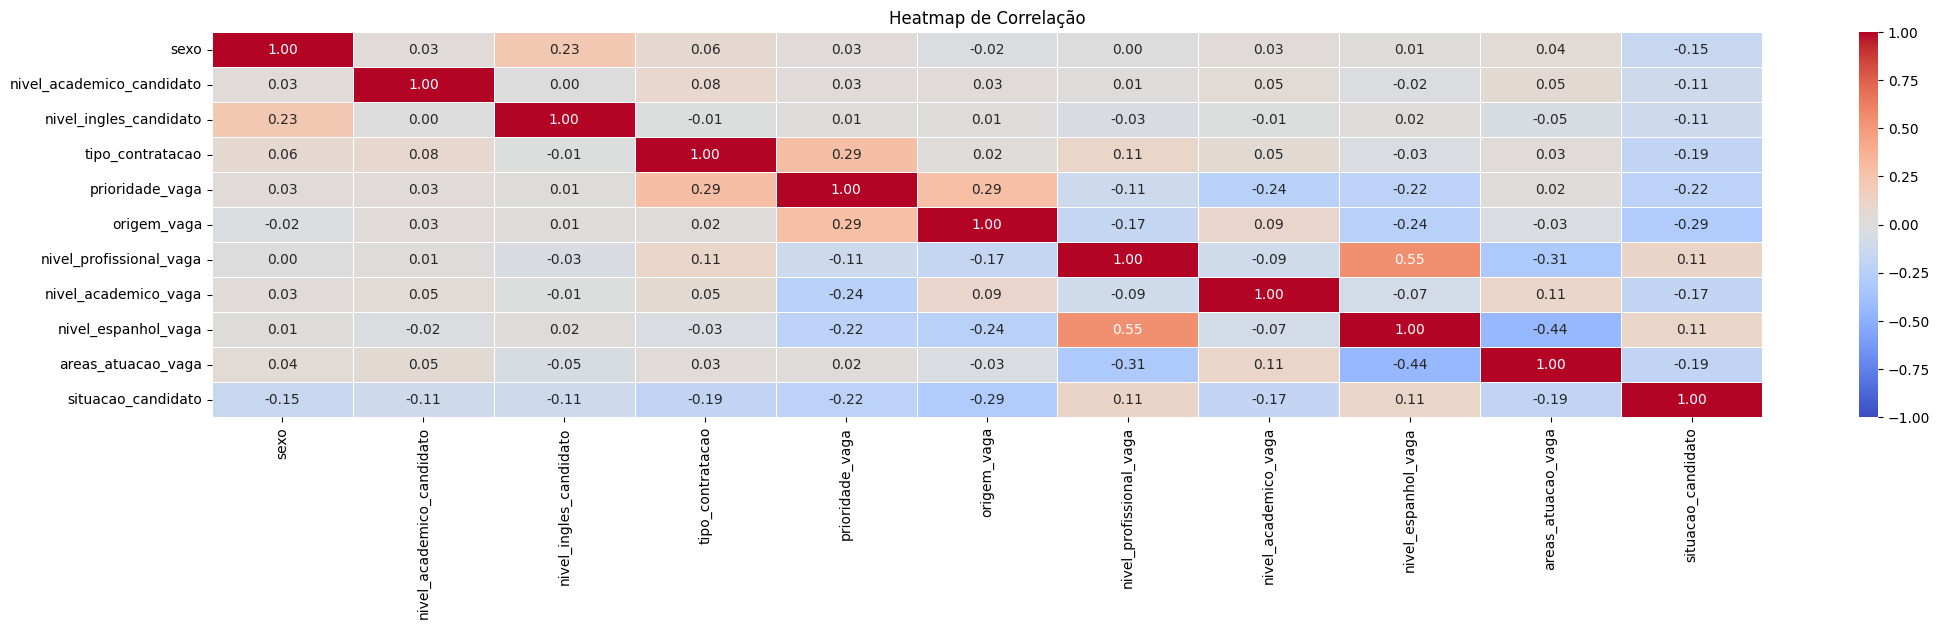

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a correlação
correlation_matrix = df.corr()

# Ajusta o tamanho da figura
plt.figure(figsize=(25, 5))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Título
plt.title("Heatmap de Correlação")

# Exibir o gráfico
plt.show()

In [43]:
df.corr()["situacao_candidato"]

sexo                        -0.153975
nivel_academico_candidato   -0.107598
nivel_ingles_candidato      -0.109956
tipo_contratacao            -0.188984
prioridade_vaga             -0.220656
origem_vaga                 -0.289388
nivel_profissional_vaga      0.111694
nivel_academico_vaga        -0.172618
nivel_espanhol_vaga          0.107500
areas_atuacao_vaga          -0.189526
situacao_candidato           1.000000
Name: situacao_candidato, dtype: float64

In [44]:
"""Em geral:
Correlação forte: |r| ≥ 0.5
Correlação moderada: 0.3 ≤ |r| < 0.5
Correlação fraca: |r| < 0.3"""

'Em geral:\nCorrelação forte: |r| ≥ 0.5\nCorrelação moderada: 0.3 ≤ |r| < 0.5\nCorrelação fraca: |r| < 0.3'

Treinamento do modelo

Acurácia: 72.20%


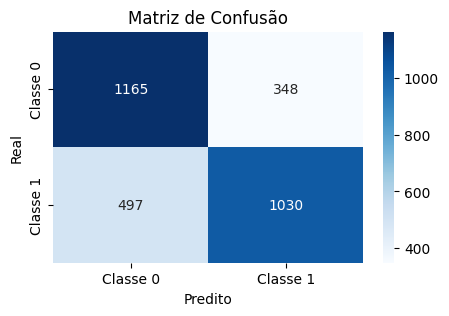

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      1513
           1       0.75      0.67      0.71      1527

    accuracy                           0.72      3040
   macro avg       0.72      0.72      0.72      3040
weighted avg       0.72      0.72      0.72      3040



In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Divisão entre dados de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instancia o modelo de Regressão Logística
model = LogisticRegression(max_iter=1000)

# Treina o modelo com os dados de treino
model.fit(X_train, y_train)

# Realiza previsões nos dados de teste
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred) * 100  # Acurácia em porcentagem
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibe a acurácia em porcentagem
print(f'Acurácia: {accuracy:.2f}%')

# Exibe a Matriz de Confusão como um Heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Relatório de Classificação
print(f'Relatório de Classificação:\n{classification_report(y_test, y_pred)}')

Acurácia: 93.16%
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      1513
           1       0.95      0.91      0.93      1527

    accuracy                           0.93      3040
   macro avg       0.93      0.93      0.93      3040
weighted avg       0.93      0.93      0.93      3040



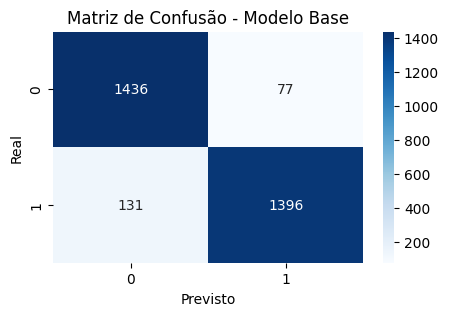

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Melhores hiperparâmetros: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200}
Melhor acurácia (validação cruzada): 93.32%
Relatório de Classificação (Melhor Modelo):
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1513
           1       0.95      0.92      0.94      1527

    accuracy                           0.94      3040
   macro avg       0.94      0.94      0.94      3040
weighted avg       0.94      0.94      0.94      3040



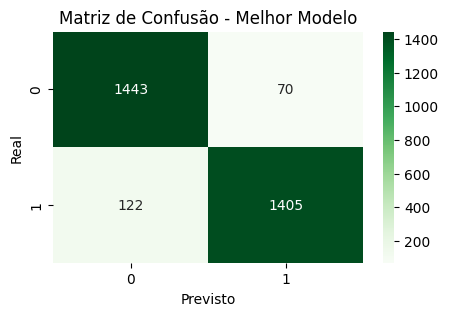

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# 🔹 Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Criando e treinando o modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# 🔹 Fazendo previsões
y_pred = model.predict(X_test)

# 🔹 Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.2%}")
print("Relatório de Classificação:\n", report)

# 🔹 Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Base")
plt.show()

# 🔹 Ajuste de hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), 
                           param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# 🔹 Melhor modelo encontrado
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor acurácia (validação cruzada): {best_accuracy:.2%}")

# 🔹 Avaliação no conjunto de teste
y_pred_best = best_model.predict(X_test)
print("Relatório de Classificação (Melhor Modelo):\n", classification_report(y_test, y_pred_best))

# 🔹 Matriz de confusão do melhor modelo
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Greens", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Melhor Modelo")
plt.show()


In [47]:
# a acurácia do modelo melhorou muito. Precision, recall e f1-score estão bem equilibrados, então o modelo já está ótimo

Validação do modelo

Acurácia no conjunto de validação: 93.68%
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1513
           1       0.95      0.92      0.94      1527

    accuracy                           0.94      3040
   macro avg       0.94      0.94      0.94      3040
weighted avg       0.94      0.94      0.94      3040



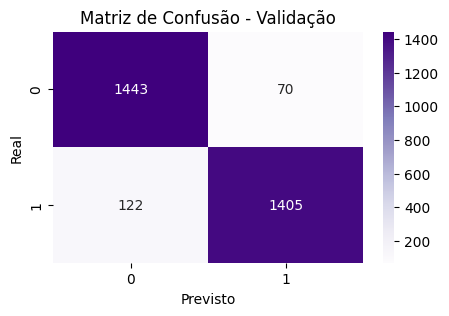

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

# 🔹 Fazer previsões no conjunto de validação
y_val_pred = best_model.predict(X_test)

# 🔹 Avaliar desempenho
accuracy = accuracy_score(y_test, y_val_pred)
print(f"Acurácia no conjunto de validação: {accuracy:.2%}")

print("Relatório de Classificação:\n", classification_report(y_test, y_val_pred))

# 🔹 Matriz de Confusão
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_val_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Validação")
plt.show()

In [49]:
# Acurácia no conjunto de validação está praticamente idêntica à do treino , indicando que o modelo não está overfittado e generaliza bem

In [50]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Acurácia Média (Cross Validation): {cv_scores.mean():.2%}")
print(f"Desvio Padrão: {cv_scores.std():.2%}")

Acurácia Média (Cross Validation): 90.51%
Desvio Padrão: 3.74%


In [51]:
# A acurácia média no Cross Validation é boa, mas um pouco menor do que no conjunto de teste
# O desvio padrão sugere uma variação razoável entre os folds. Isso significa que o modelo pode estar sofrendo um pouco de sensibilidade aos dados de treino.

In [52]:
# Identificar exemplos que o modelo previu errado
erros = X_test[y_test != y_val_pred]
erros.head()

,sexo,nivel_ingles_candidato,tipo_contratacao,prioridade_vaga,origem_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga
7934,0.587252,1.415580,0.582905,1.329932,0.394093,0.886117,-1.53161,0.062657,-0.966004,0.963622
2512,0.587252,-0.505507,-0.985681,-1.170115,-0.986141,-1.009054,0.47808,0.851058,0.933267,0.963622
14793,0.587252,-0.825688,-0.985681,-1.170115,0.394093,0.886117,-1.53161,0.062657,-0.966004,-0.084790
4295,0.587252,-0.825688,-0.201388,-1.170115,0.394093,0.886117,-1.53161,0.062657,-0.966004,-0.084790
9317,0.587252,1.415580,-0.201388,1.017426,0.394093,-1.009054,0.47808,0.062657,0.933267,0.655265


In [53]:
# O modelo já está bem testado e validado
# ✔ Acurácia alta e estável → no conjunto de validação e no Cross Validation.
# ✔ Sem overfitting grave → Pequena diferença entre treino e teste, sem queda brusca de performance.
# ✔ Cross Validation feito → O modelo foi avaliado em diferentes amostras dos dados.
# ✔ Relatórios de classificação analisados → Precision, Recall e F1-score equilibrados.
# ✔ Matriz de confusão revisada → Nenhuma distorção grave na previsão das classes.

In [54]:
import joblib

# 🔹 Salvando o modelo
joblib.dump(best_model, "modelo_xgboost.joblib")

# 🔹 Carregando o modelo posteriormente
modelo_carregado = joblib.load("modelo_xgboost.joblib")

# Teste de carregamento
print(modelo_carregado.predict(X_test[:5]))

[0 0 0 1 0]
